In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

from theano import tensor as tt
from scipy import stats
import theano

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Chapter 10 - Memory retention
  
This Chapter is about estimating the relationship between memory retention and time.
The model being considered is a simplified version of the exponential decay model. The model assumes that the probability that an item will be remembered after a period of time $t$ has elapsed is $\theta_{t} = \text{exp}(−\alpha t)+\beta$, with the restriction $0 < \theta_{t} < 1$. The $\alpha$ parameter corresponds to the rate of decay of information. The $\beta$ parameter corresponds to a baseline level of remembering that is assumed to remain even after very long time periods.
  
## 10.1 No individual differences


$$ \alpha \sim \text{Beta}(1,1)$$
$$ \beta \sim \text{Beta}(1,1)$$
$$ \theta_{j} = \text{min}(1,\text{exp}(−\alpha t_{j})+\beta)$$
$$ k_{ij} \sim \text{Binomial}(\theta_{j},n)$$

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [kij_missing]
>NUTS: [beta_logodds__, alpha_logodds__]
100%|██████████| 4000/4000 [00:19<00:00, 207.40it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


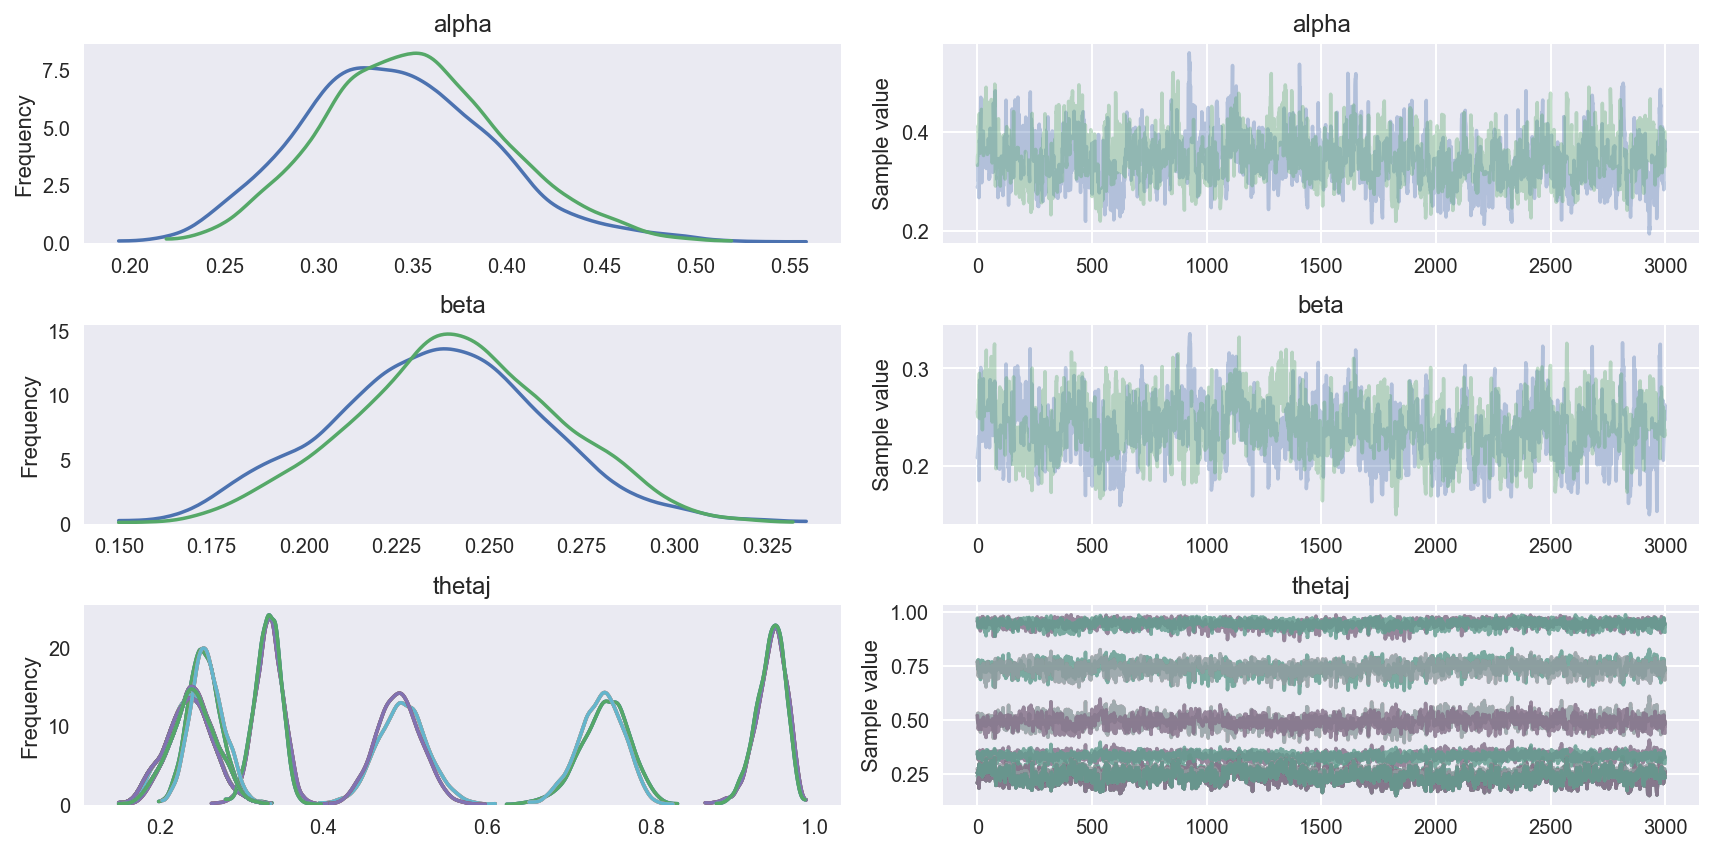

In [2]:
t     = np.array([1, 2, 4, 7, 12, 21, 35, 59, 99, 200])
nt    = len(t)
# slist = [0,1,2,3]
ns    = 4
tmat  = np.repeat(t,ns).reshape(nt,-1).T
k1 = np.ma.masked_values([18, 18, 16, 13, 9, 6, 4, 4, 4, -999,
                          17, 13,  9,  6, 4, 4, 4, 4, 4, -999,
                          14, 10,  6,  4, 4, 4, 4, 4, 4, -999,
                          -999, -999, -999, -999, -999, -999, -999, -999, -999, -999], 
                          value=-999).reshape(ns,-1)
n = 18

with pm.Model() as model1:
    # prior
    alpha = pm.Beta('alpha', alpha=1, beta=1, testval=.30)
    beta = pm.Beta('beta', alpha=1, beta=1, testval=.25)
    
    # parameter transformation
    theta = tt.exp(-alpha*tmat)+beta
    #thetaj = pm.Deterministic('thetaj', tt.clip(theta, 0, 1))
    thetaj = pm.Deterministic('thetaj', tt.minimum(theta, 1))
    
    kij = pm.Binomial('kij', p=thetaj, n=n, observed=k1)
    
    trace1 = pm.sample(3000, tune=1000, nuts_kwargs={'target_accept': .99})

pm.traceplot(trace1, varnames=['alpha', 'beta', 'thetaj']);

The above model is very sensitivity to the starting value. We can specified a starting value for each parameter by assigning a `testval` when the RV is created:
```python
alpha = pm.Beta('alpha', alpha=1, beta=1, testval=.35)
```

In fact, with a bad starting value, NUTS really have difficulty sampling and we see `Bad initial energy` error. The reason being that bounding the theta gives 0 gradient, and causing problem as NUTS require gradient to work.

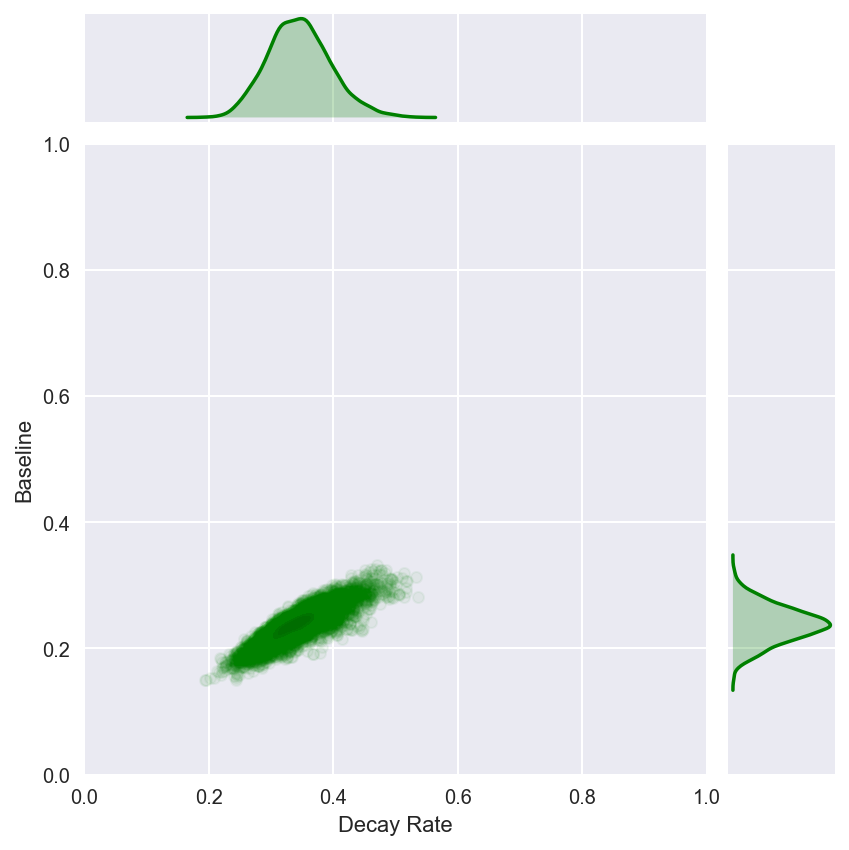

In [3]:
# reproduce Fig 10.2
burnin = 1000

xtrace = trace1['alpha'][burnin:]
ytrace = trace1['beta'][burnin:]

datmp2 = np.vstack((xtrace, ytrace))

df2 = pd.DataFrame(datmp2.transpose(), columns=["x", "y"])

g = sns.jointplot(x="x", y="y", data=df2, kind="kde", color="g", 
                  stat_func=None ,xlim=(0,1), ylim=(0,1))
g.plot_joint(plt.scatter, c="g", s=30, linewidth=1, alpha=.05)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels('Decay Rate', 'Baseline')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

100%|██████████| 500/500 [00:00<00:00, 974.37it/s]


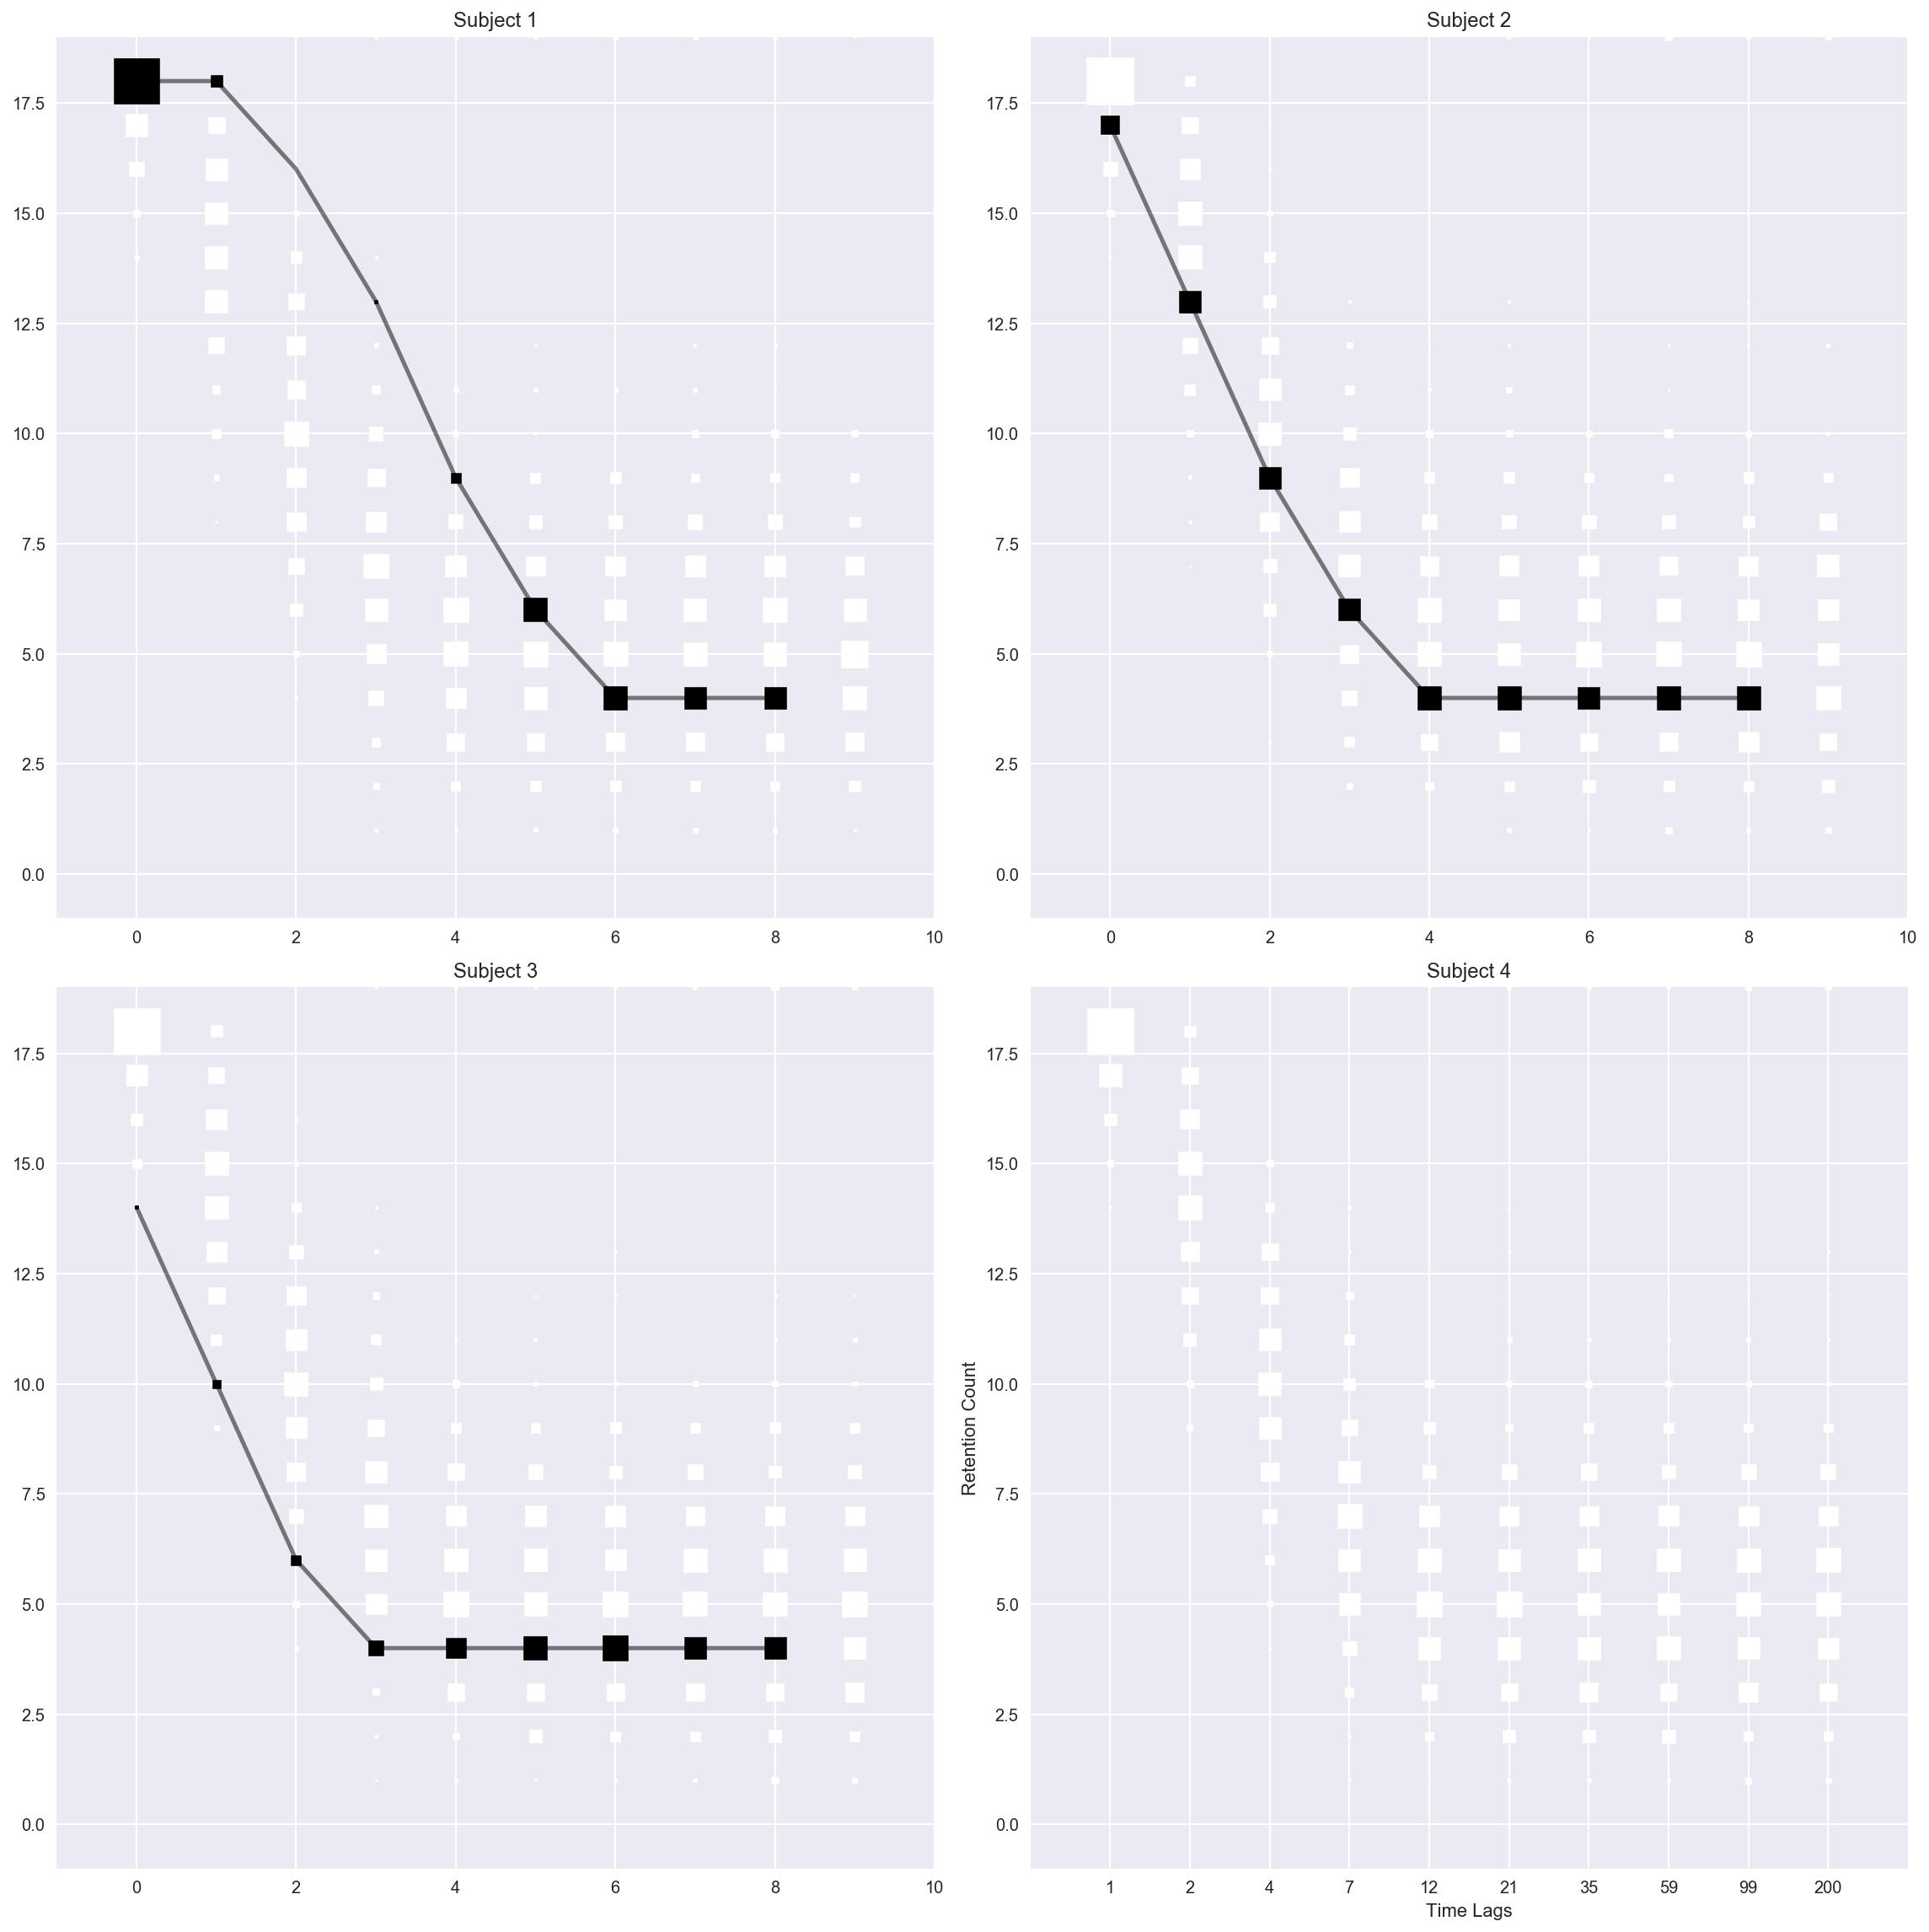

In [4]:
# reproduce Fig 10.3
# The posterior predictive distribution for the model that assumes no individual
# differences.
ppc = pm.sample_ppc(trace1[burnin:], model=model1, samples=500)
predictrace = ppc['kij']
def plot_predict(predictrace):
    ns_, t_ = predictrace.shape[1:]
    _, axes = plt.subplots(2, 2, figsize=(16, 16))
    bins = np.arange(0, n+1)
    ax = axes.flatten()
    for ip in np.arange(ns_):
        ispredi = np.squeeze(predictrace[:, ip, :])
        ax1 = ax[ip]
        for itt in np.arange(t_):
            y2, binEdges2 = np.histogram(ispredi[:, itt], bins=bins, normed=True)
            ax1.scatter(itt*np.ones(bins.size), binEdges2+1, s=y2*1000, c='w', marker='s')
            if (k1[ip,itt] is np.ma.masked)==0:
                ax1.scatter(itt, k1[ip,itt], s=y2[k1[ip,itt]-1]*1000, c='k', marker='s')
        ax1.plot(np.arange(len(t)), k1[ip, :], 'k', lw=2.5, alpha=.5)
        ax1.set_xlim(-1,10)
        ax1.set_ylim(-1,19)
        ax1.set_title('Subject %s'%(ip+1))
    plt.xticks(np.arange(len(t)), t)
    plt.xlabel('Time Lags')
    plt.ylabel('Retention Count')
    plt.tight_layout();
    
plot_predict(predictrace)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = inf:   4%|▍         | 7753/200000 [00:01<00:29, 6529.32it/s]
Convergence archived at 7900
Interrupted at 7,899 [3%]: Average Loss = 80.308
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_logodds__, alpha_logodds__]
100%|██████████| 4000/4000 [00:09<00:00, 420.77it/s]
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


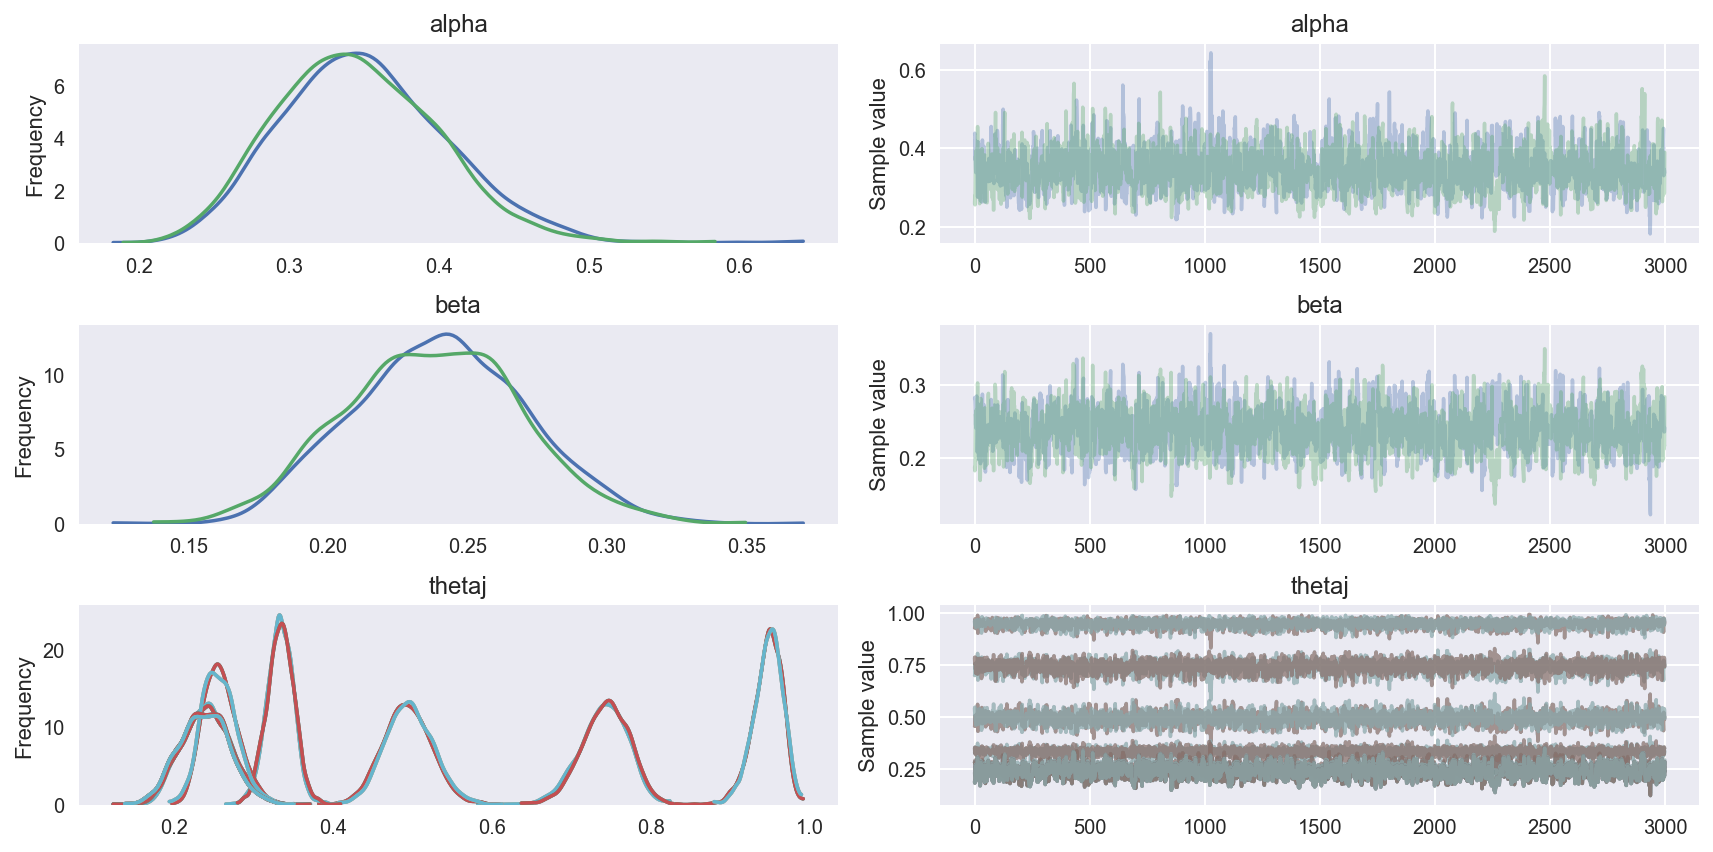

In [5]:
t2     = np.array([1, 2, 4, 7, 12, 21, 35, 59, 99])
nt2    = len(t2)
# slist = [0,1,2,3]
ns2    = 3
tmat2  = np.repeat(t2,ns2).reshape(nt2,-1).T
k2 = np.asarray([18, 18, 16, 13, 9, 6, 4, 4, 4, 
                 17, 13,  9,  6, 4, 4, 4, 4, 4, 
                 14, 10,  6,  4, 4, 4, 4, 4, 4]).reshape(ns2,-1)

with pm.Model() as model1_:
    # prior
    alpha = pm.Beta('alpha', alpha=1, beta=1)
    beta = pm.Beta('beta', alpha=1, beta=1)
    
    # parameter transformation
    theta = tt.exp(-alpha*tmat2)+beta
    thetaj = pm.Deterministic('thetaj', tt.clip(theta, 0, 1))
    
    kij = pm.Binomial('kij', p=thetaj, n=n, observed=k2)
    
    # generate ppc
    theta2 = tt.minimum(tt.exp(-alpha*tmat)+beta, 1.)
    rng = tt.shared_randomstreams.RandomStreams()
    kij_ppc = pm.Deterministic('kij_ppc', rng.binomial(n=n, p=theta2))
    
    trace1_ = pm.sample(3000, tune=1000, njobs=2, init='advi')

pm.traceplot(trace1_, varnames=['alpha', 'beta', 'thetaj']);

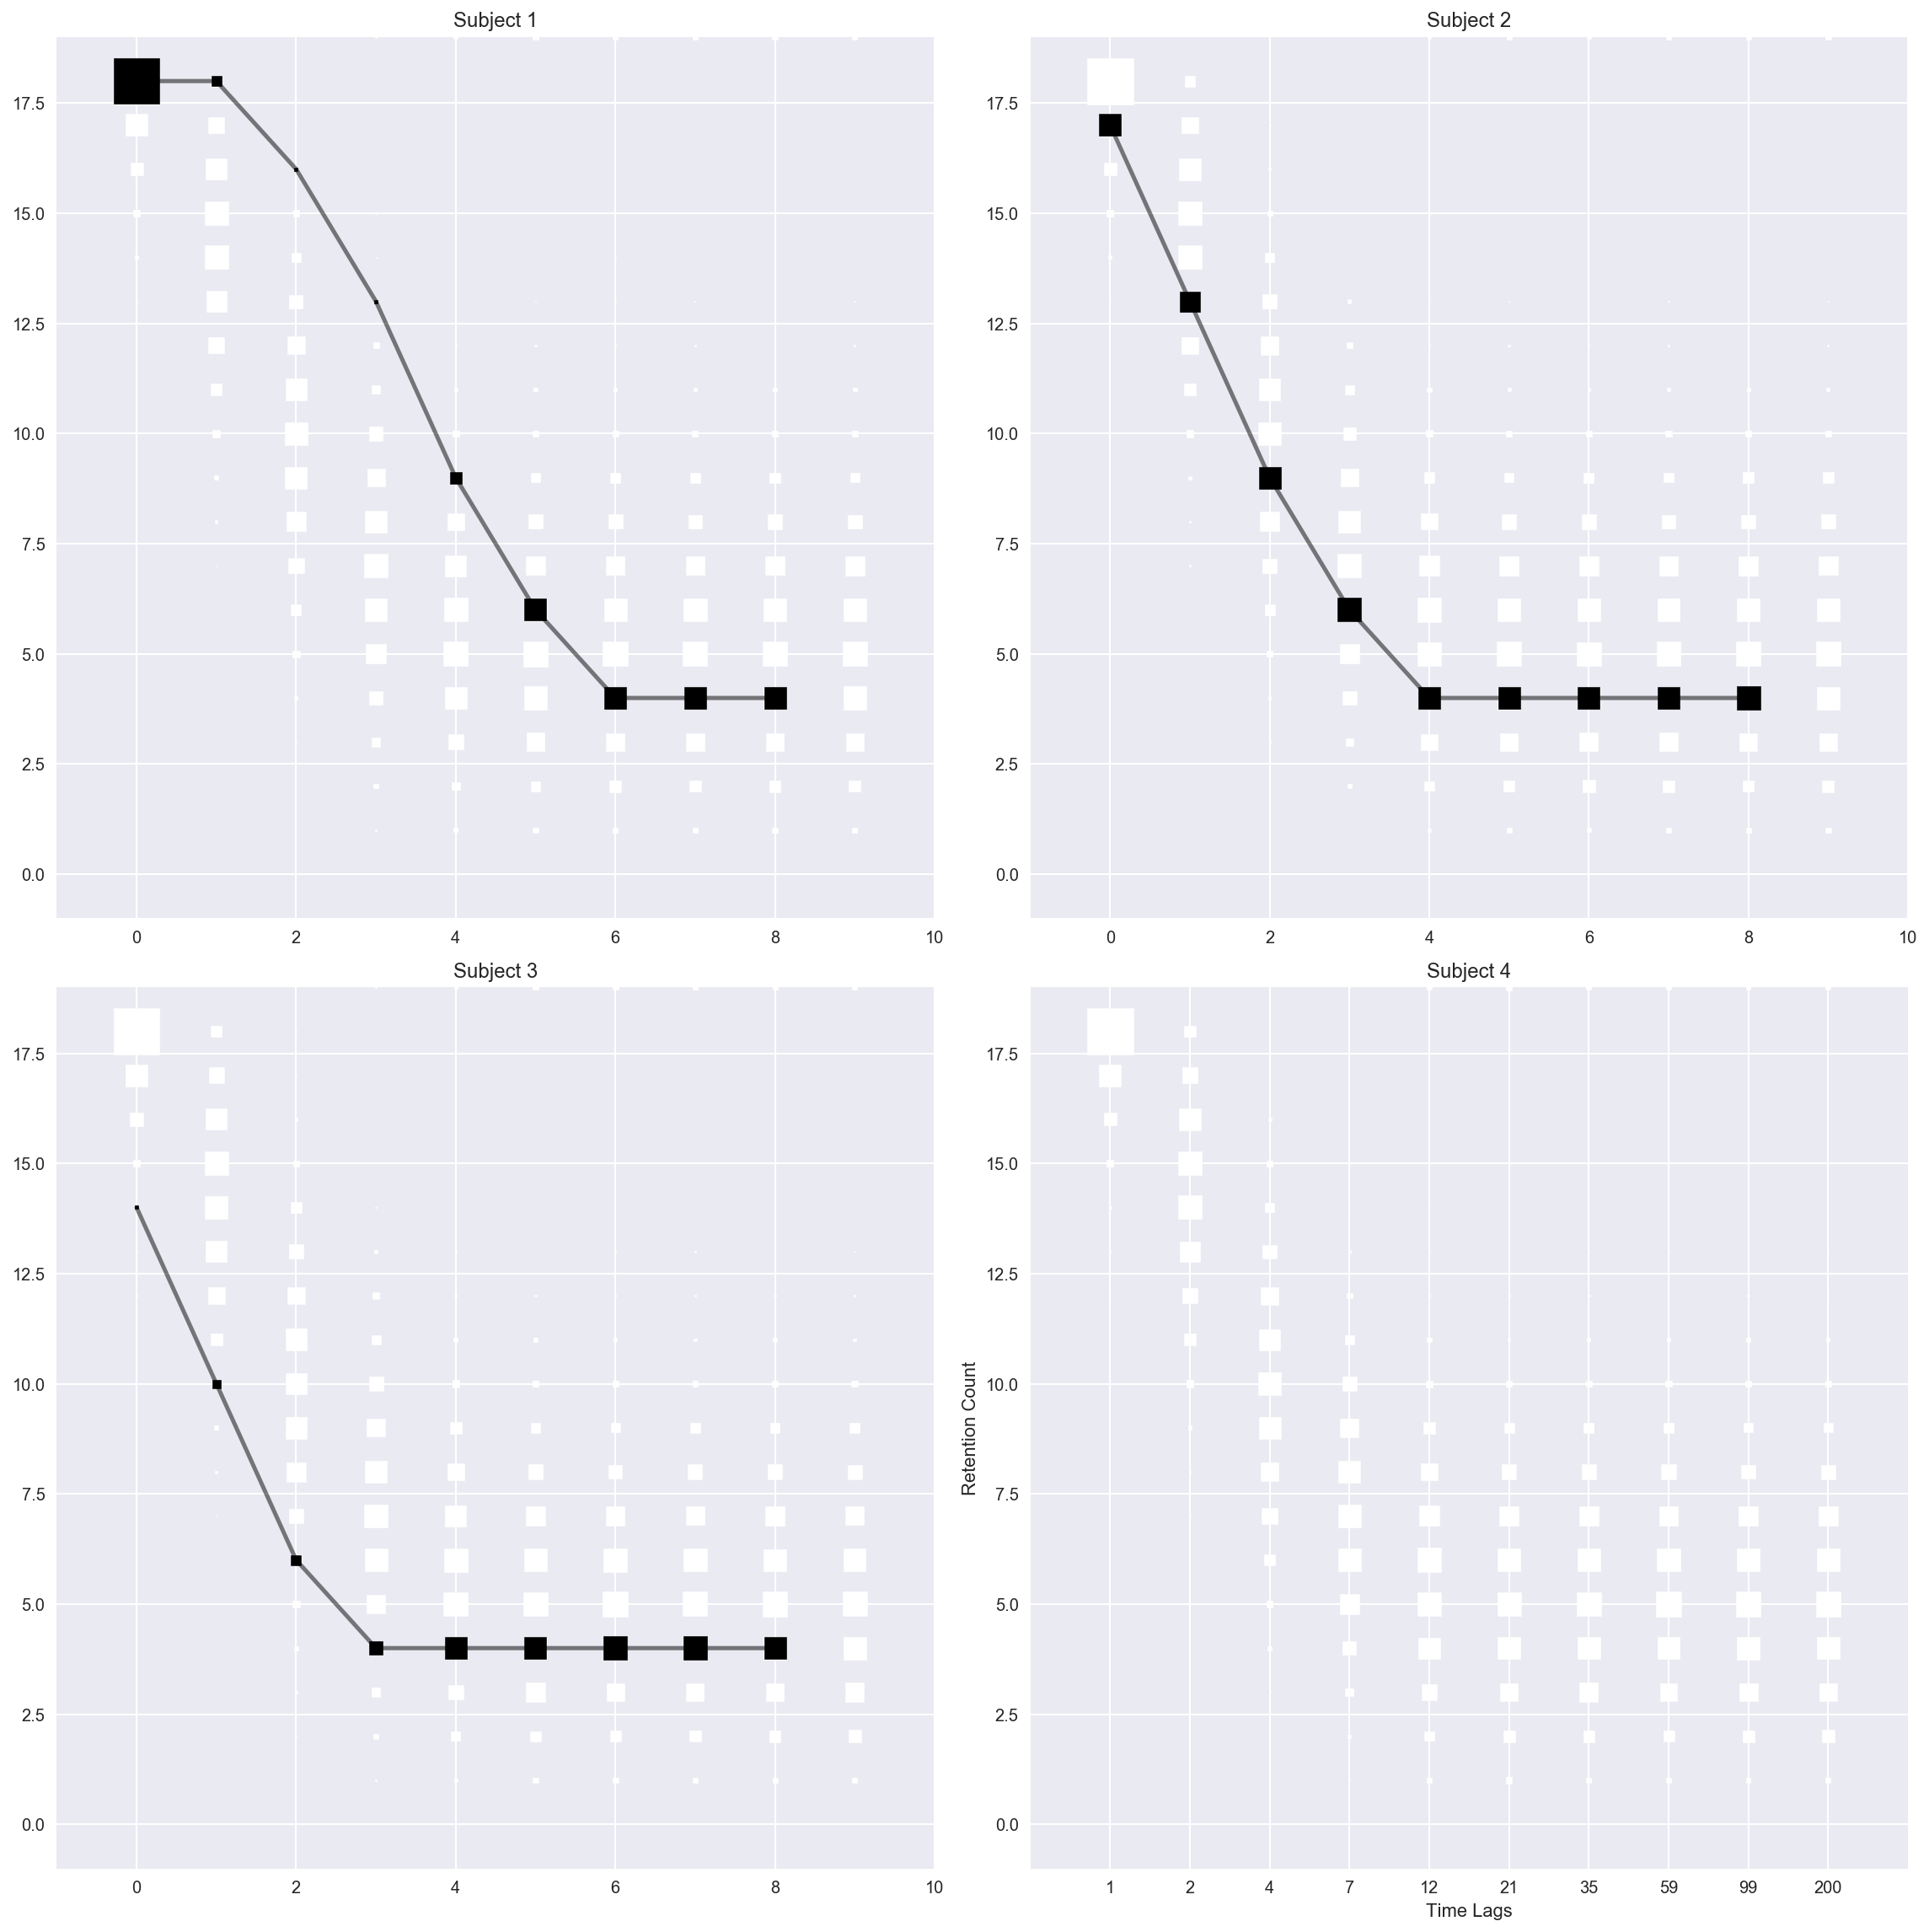

In [6]:
plot_predict(trace1_['kij_ppc'])

## 10.2 Full individual differences


$$ \alpha_{i} \sim \text{Beta}(1,1)$$
$$ \beta_{i} \sim \text{Beta}(1,1)$$
$$ \theta_{ij} = \text{min}(1,\text{exp}(−\alpha_{i} t_{j})+\beta_{i})$$
$$ k_{ij} \sim \text{Binomial}(\theta_{ij},n)$$

In [7]:
with pm.Model() as model2_:
    alpha = pm.Beta('alpha', alpha=1, beta=1, 
                    shape=(1, ns), testval=np.asarray([[.3, .3, .3, .5]]))
    beta = pm.Beta('beta', alpha=1, beta=1, 
                   shape=(1, ns), testval=np.asarray([[.25, .25, .25, .5]]))
    
    theta = (tt.exp(-alpha[:, :ns2]*t2[:,None]) + beta[:, :ns2]).T
    thetaj = pm.Deterministic('thetaj', tt.clip(theta, 0, 1))
    
    kij = pm.Binomial('kij', p=thetaj, n=n, observed=k2)
    
    # generate ppc
    theta2 = tt.minimum((tt.exp(-alpha*t[:, None])+beta).T, 1.)
    rng = tt.shared_randomstreams.RandomStreams()
    kij_ppc = pm.Deterministic('kij_ppc', rng.binomial(n=n, p=theta2))

Due to the difficulty of the model as explained above, here I do inference using fullrank_advi. The result seems quite comparable to JAGS actually.

In [8]:
with model2_:
#     trace2_ = pm.sample(1e4, tune=1000, init='advi', njobs=2, nuts_kwargs={'target_accept': .99})
    
    # ADVI
    s = theano.shared(pm.floatX(1))
    inference = pm.FullRankADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace2_ = approx.sample(3000, include_transformed=True) 
    
    elbos1 = -inference.hist

Average Loss = inf: 100%|██████████| 20000/20000 [00:11<00:00, 1685.41it/s]
Finished [100%]: Average Loss = nan
Average Loss = inf: 100%|██████████| 10000/10000 [00:05<00:00, 1688.83it/s]
Finished [100%]: Average Loss = nan


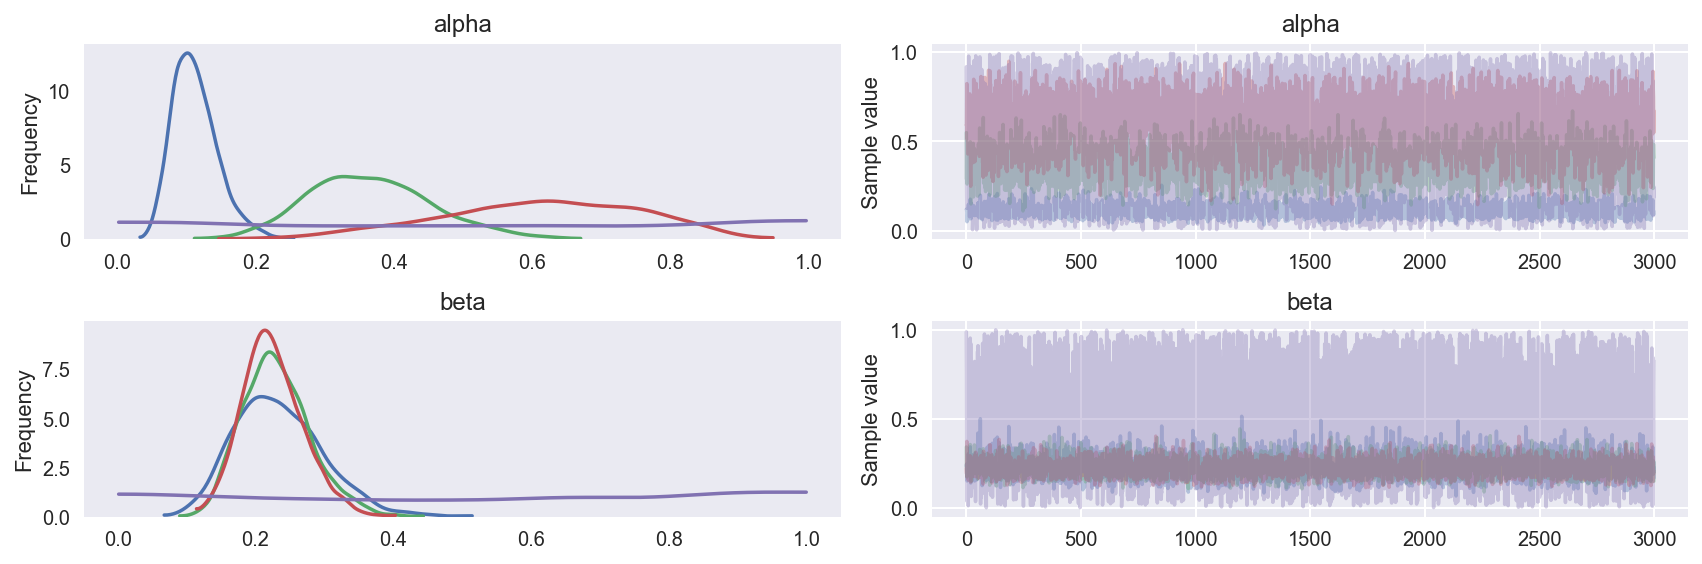

In [9]:
pm.traceplot(trace2_, varnames=['alpha', 'beta']);

In [10]:
# reproduce Fig 10.5
def scatter_alpha_beta(trace):
    from matplotlib.ticker import NullFormatter
    nullfmt = NullFormatter()         # no labels
    xtrace = trace['alpha'][:1000].squeeze()
    ytrace = trace['beta'][:1000].squeeze()
    ns_ = xtrace.shape[1]

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # now determine limits by hand:
    binwidth1 = 0.25

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))

    cc = ['C0', 'C1', 'C2', 'C3']

    for iss in np.arange(ns_):
        x=xtrace[:, iss]
        y=ytrace[:, iss]

        axScatter = plt.axes(rect_scatter)
        axScatter.set_xlim((0, 1))
        axScatter.set_ylim((0, 1))

        axHistx = plt.axes(rect_histx)
        axHisty = plt.axes(rect_histy)

        # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)

        # the scatter plot:
        axScatter.scatter(x, y, c=cc[iss], alpha=.1)
        axScatter.set_xlabel('Decay Rate', fontsize=18)
        axScatter.set_ylabel('Baseline', fontsize=18)

        bins1 = np.linspace(0, 1, 50)
        axHistx.hist(x, bins=bins1, color=cc[iss], alpha=.5, normed=True)
        bins2 = np.linspace(0, 1, 50)
        axHisty.hist(y, bins=bins2, color=cc[iss], alpha=.5, normed=True, orientation='horizontal')

        axHistx.set_xlim(axScatter.get_xlim())
        axHisty.set_ylim(axScatter.get_ylim())

    plt.tight_layout();

However, fitting using NUTS will give bias/different estimation compare to JAGS (same thing happens in [STAN](https://github.com/stan-dev/example-models/blob/master/Bayesian_Cognitive_Modeling/CaseStudies/MemoryRetention/Retention_2_Stan.R#L6))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


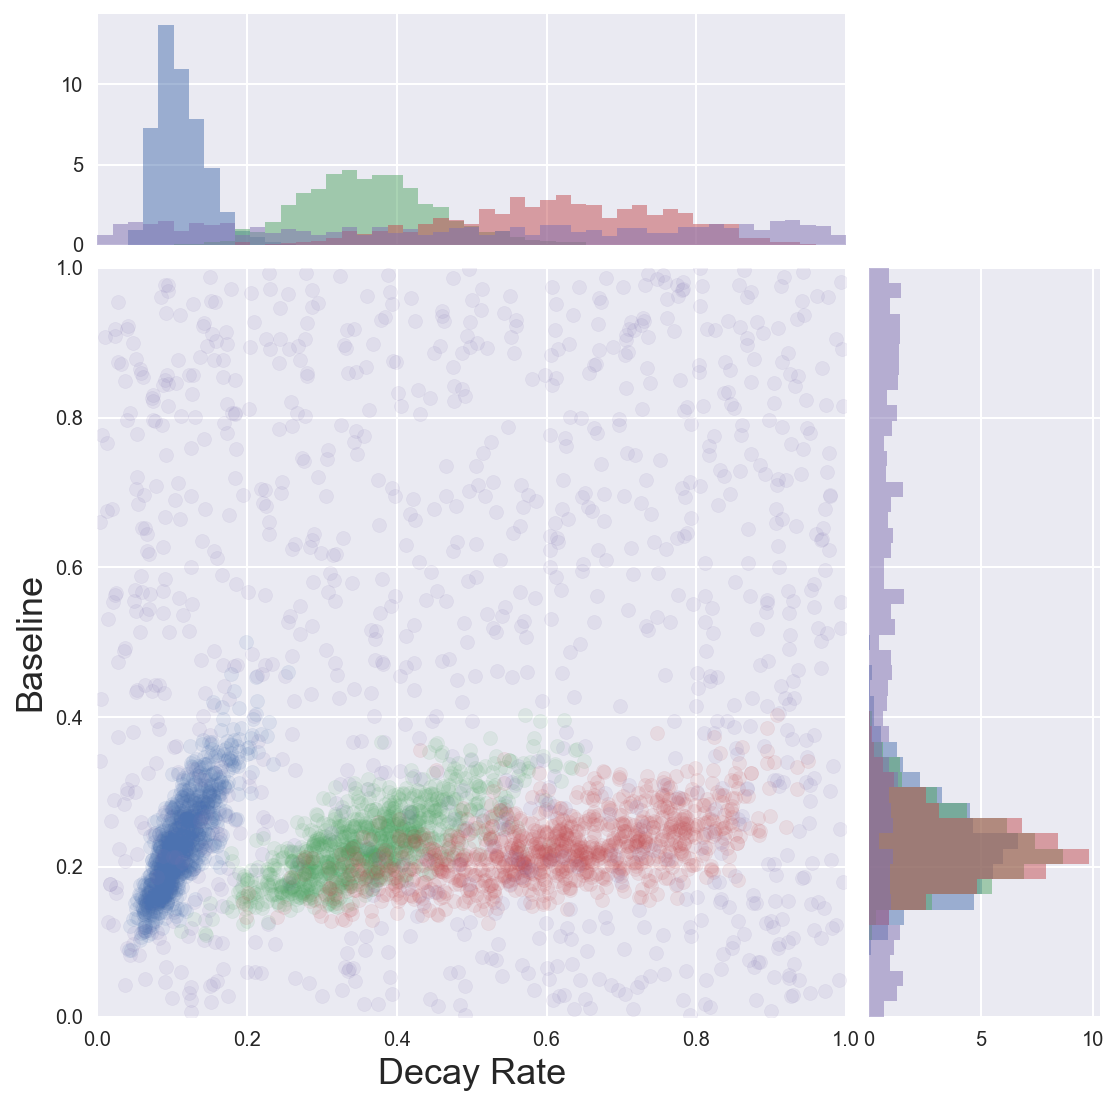

In [11]:
scatter_alpha_beta(trace2_)

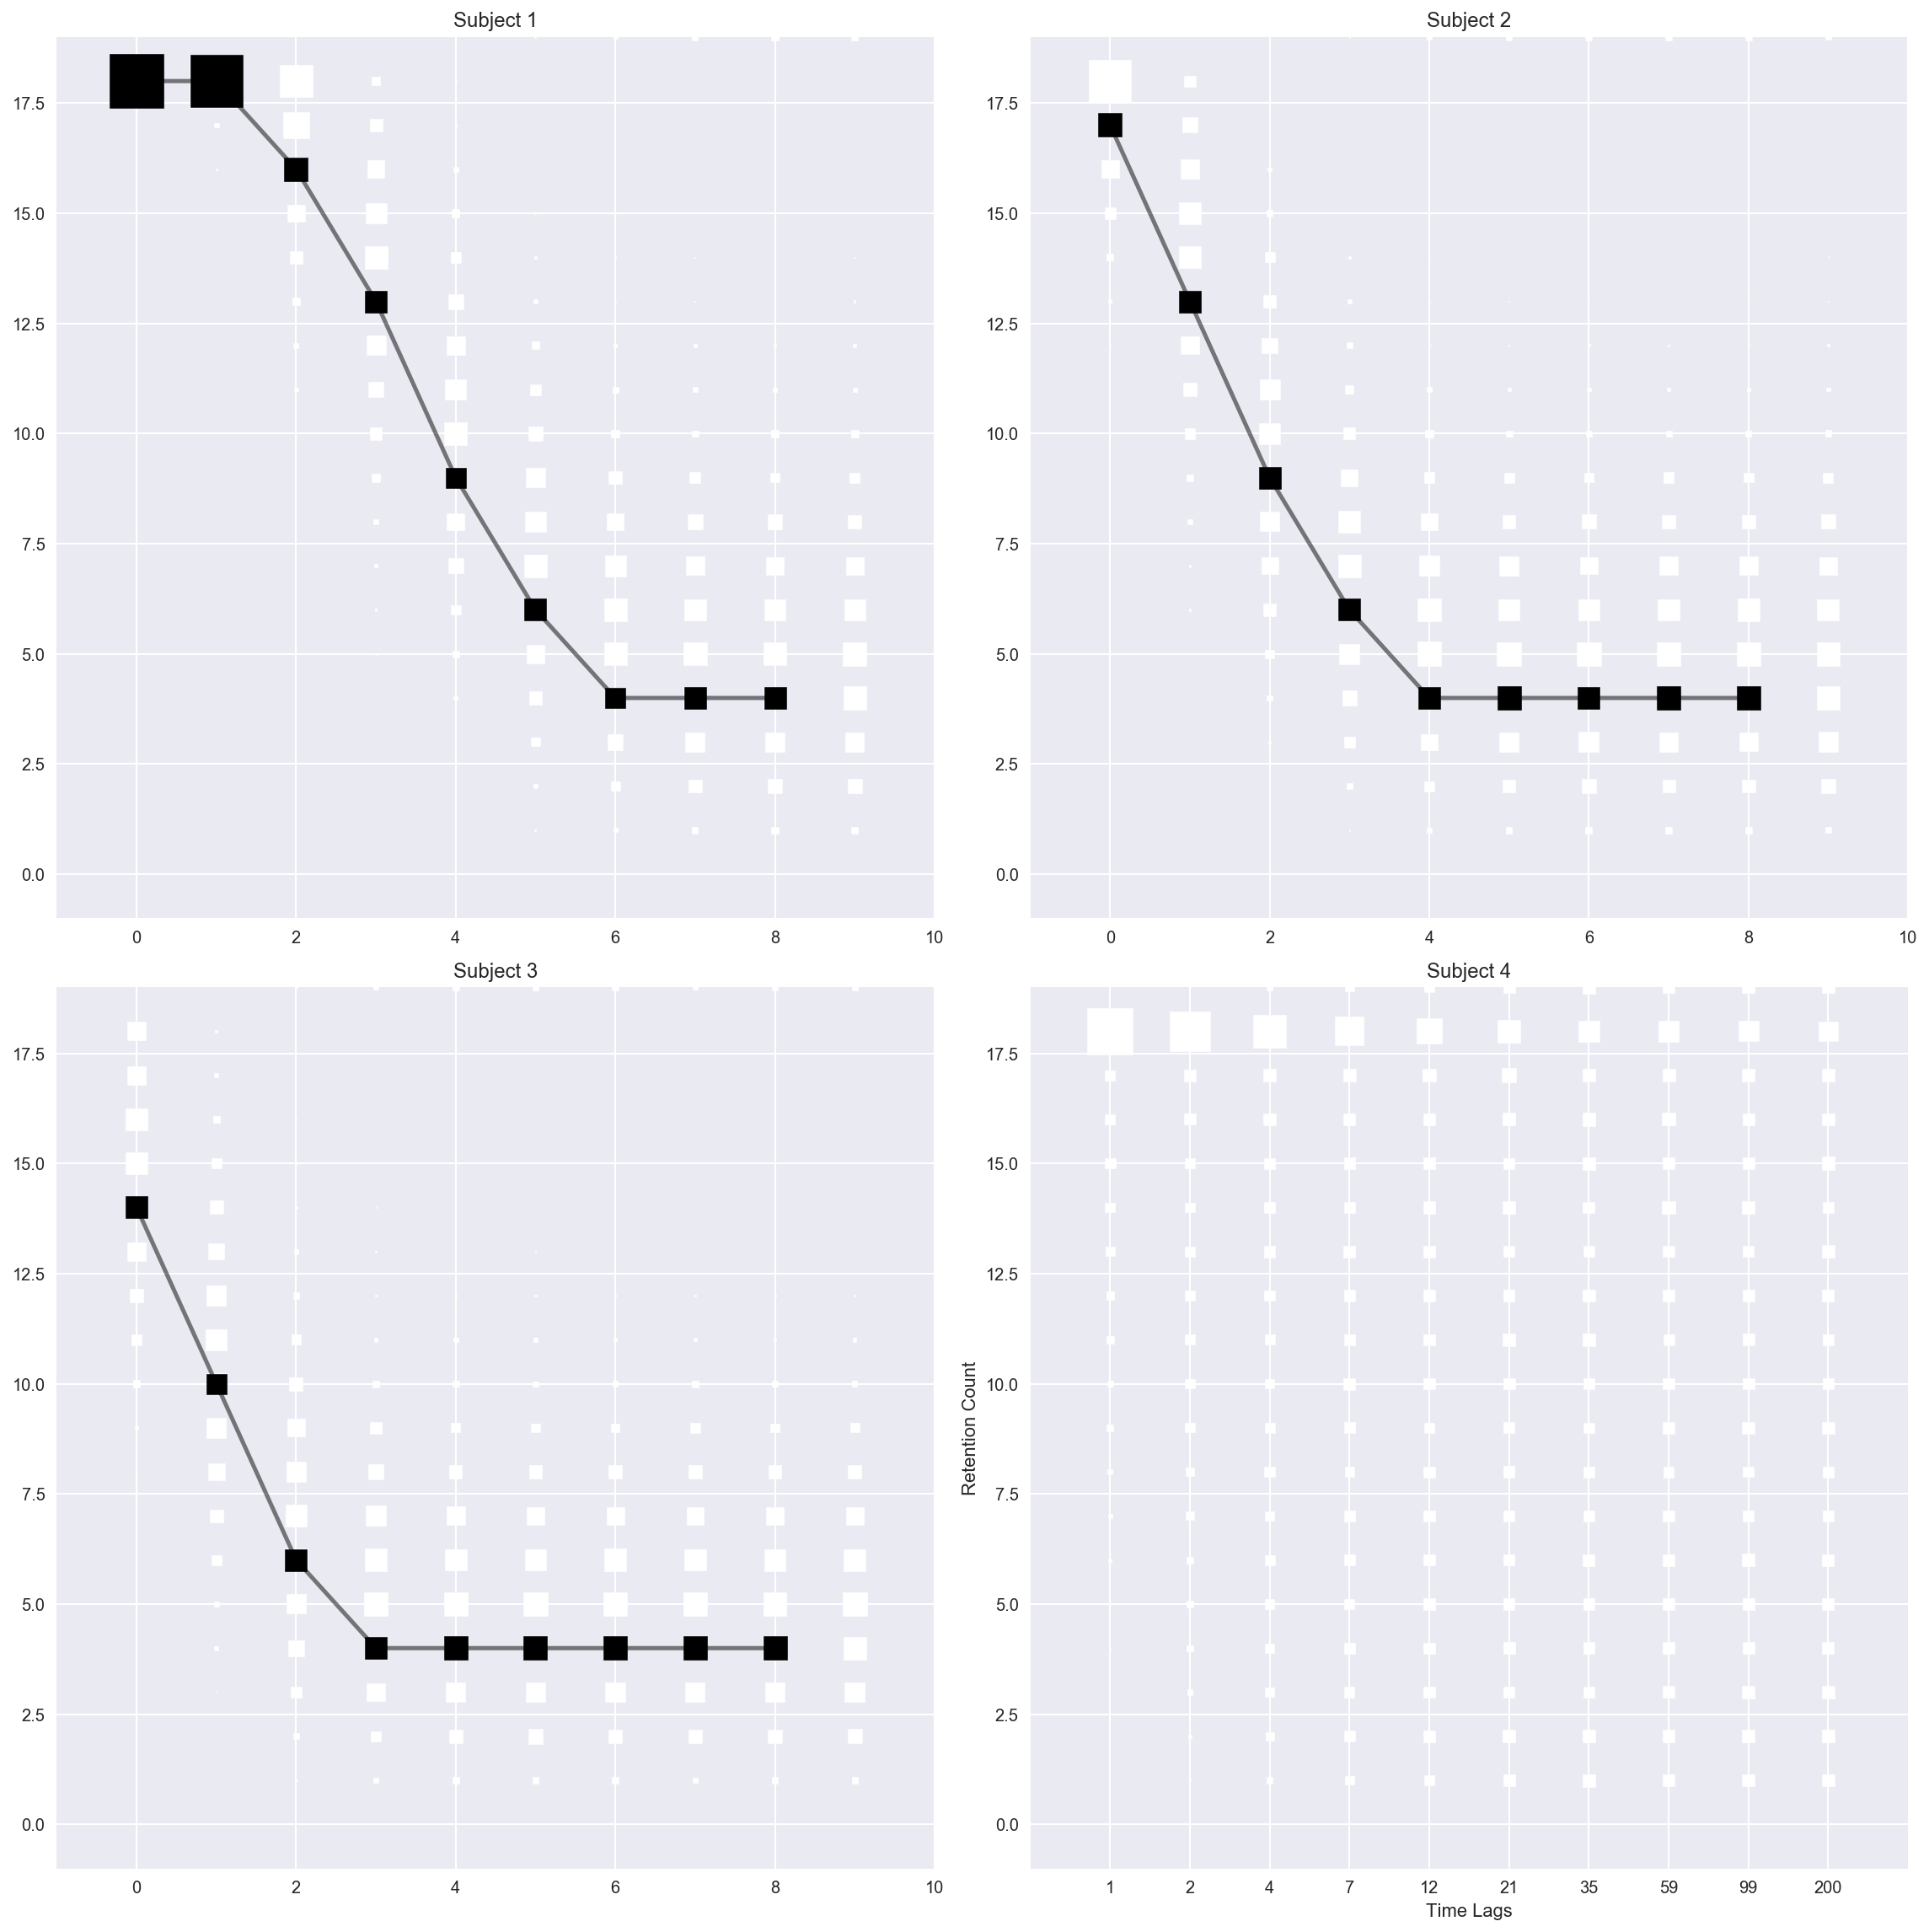

In [12]:
# reproduce Fig 10.3
# The posterior predictive distribution for the model that assumes no individual
# differences.
plot_predict(trace2_['kij_ppc'])

## 10.3 Structured individual differences


$$ \mu_{\alpha} \sim \text{Beta}(1,1)$$
$$ \lambda_{\alpha} \sim \text{Gamma}(.001,.001)$$
$$ \mu_{\beta} \sim \text{Beta}(1,1)$$
$$ \lambda_{\beta} \sim \text{Gamma}(.001,.001)$$
$$ \alpha_{i} \sim \text{Gaussian}(\mu_{\alpha}, \lambda_{\alpha})_{\mathcal I(0,1)} $$
$$ \beta_{i} \sim \text{Gaussian}(\mu_{\beta}, \lambda_{\beta})_{\mathcal I(0,1)} $$
$$ \theta_{ij} = \text{min}(1,\text{exp}(−\alpha_{i} t_{j})+\beta_{i})$$
$$ k_{ij} \sim \text{Binomial}(\theta_{ij},n)$$

Average Loss = inf: 100%|██████████| 20000/20000 [00:15<00:00, 1269.26it/s]
Finished [100%]: Average Loss = nan
Average Loss = inf: 100%|██████████| 10000/10000 [00:07<00:00, 1250.42it/s]
Finished [100%]: Average Loss = nan


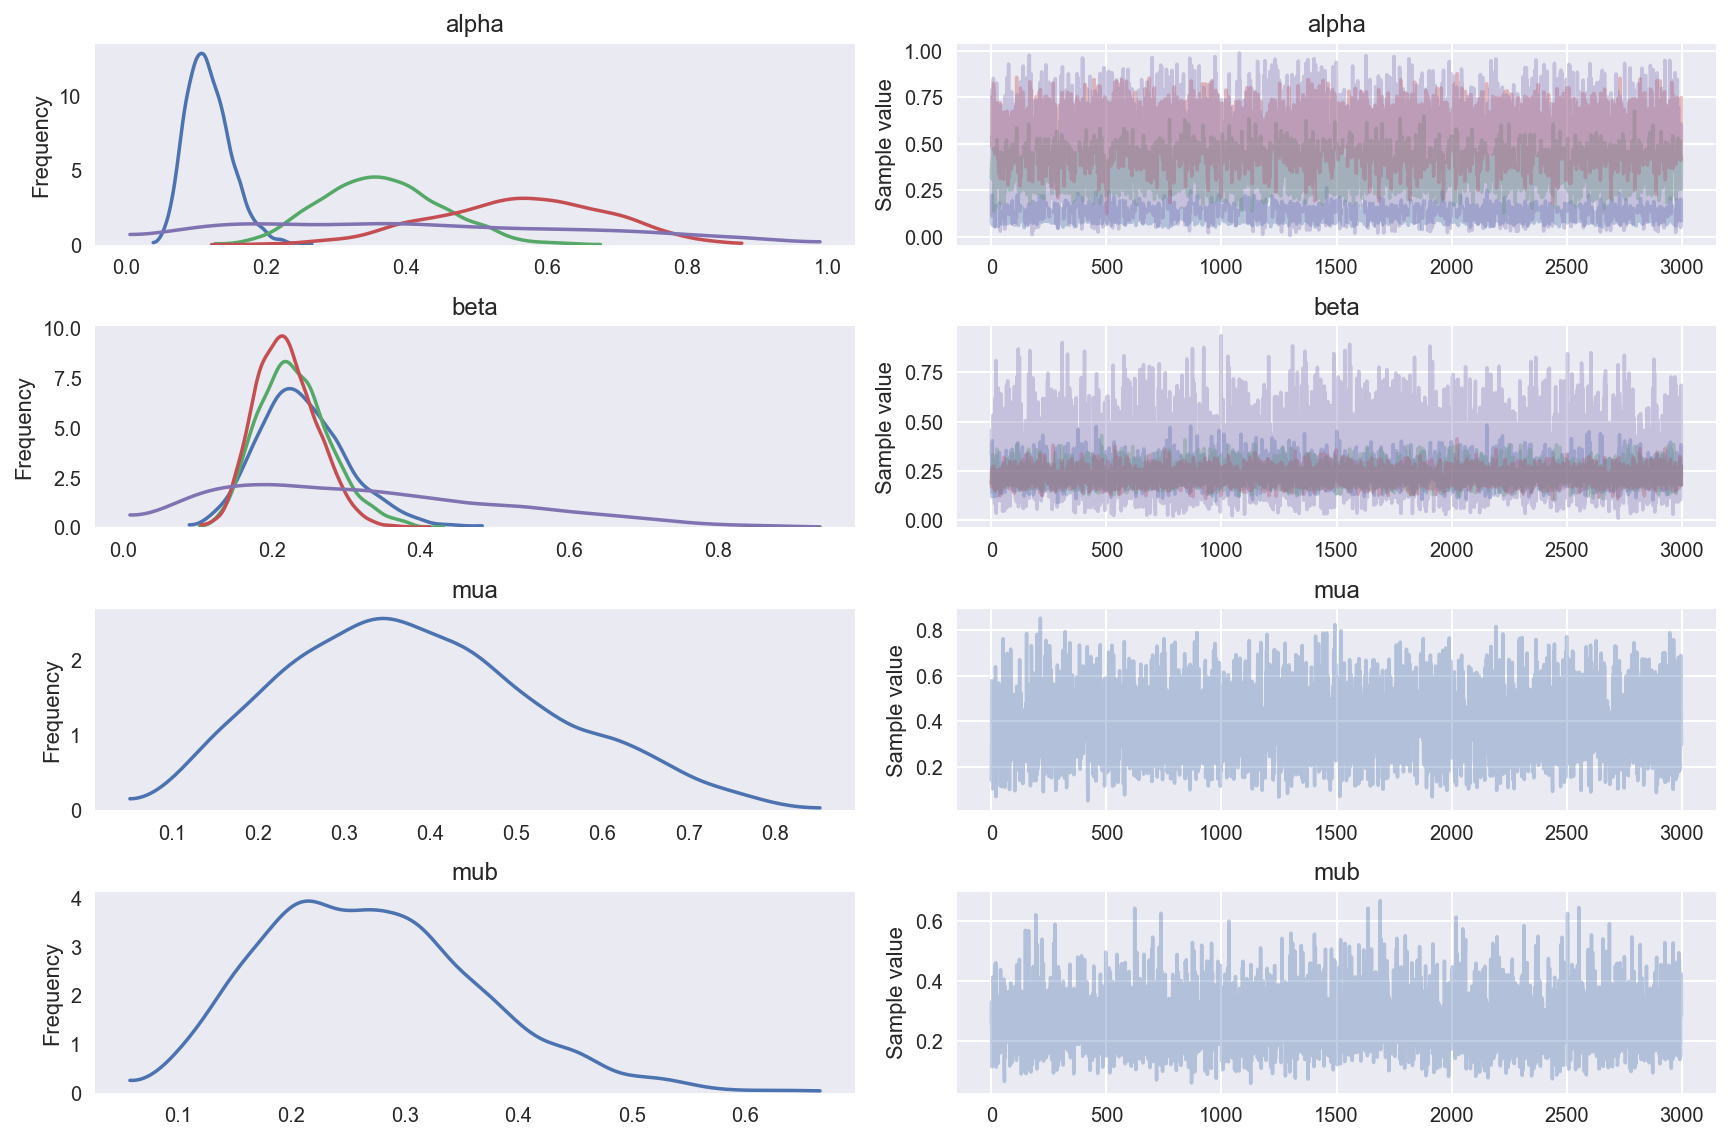

In [16]:
BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
with pm.Model() as model3:
    mua = pm.Beta('mua', alpha=1, beta=1)
    lambdaa = pm.Gamma('lambdaa', alpha=.001, beta=.001)
    mub = pm.Beta('mub', alpha=1, beta=1)
    lambdab = pm.Gamma('lambdab', alpha=.001, beta=.001)
    
    alpha = BoundedNormal('alpha', mu=mua, tau=lambdaa, shape=(1, ns))
    beta = BoundedNormal('beta', mu=mub, tau=lambdab, shape=(1, ns))
    
    theta = (tt.exp(-alpha[:, :ns2]*t2[:,None]) + beta[:, :ns2]).T
    thetaj = pm.Deterministic('thetaj', tt.minimum(theta, 1))
    
    kij = pm.Binomial('kij', p=thetaj, n=n, observed=k2)
    
    # generate ppc
    theta2 = tt.minimum((tt.exp(-alpha*t[:, None])+beta).T, 1.)
    rng = tt.shared_randomstreams.RandomStreams()
    kij_ppc = pm.Deterministic('kij_ppc', rng.binomial(n=n, p=theta2))
    
    #step = pm.NUTS(target_accept=.99)
    #trace3_ = pm.sample(1e4, tune=1000, init='advi', njobs=2)

    # ADVI
    s = theano.shared(pm.floatX(1))
    inference = pm.FullRankADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace3_ = approx.sample(3000) 
    
    elbos1 = -inference.hist
    
pm.traceplot(trace3_, varnames=['alpha', 'beta', 'mua', 'mub']);

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


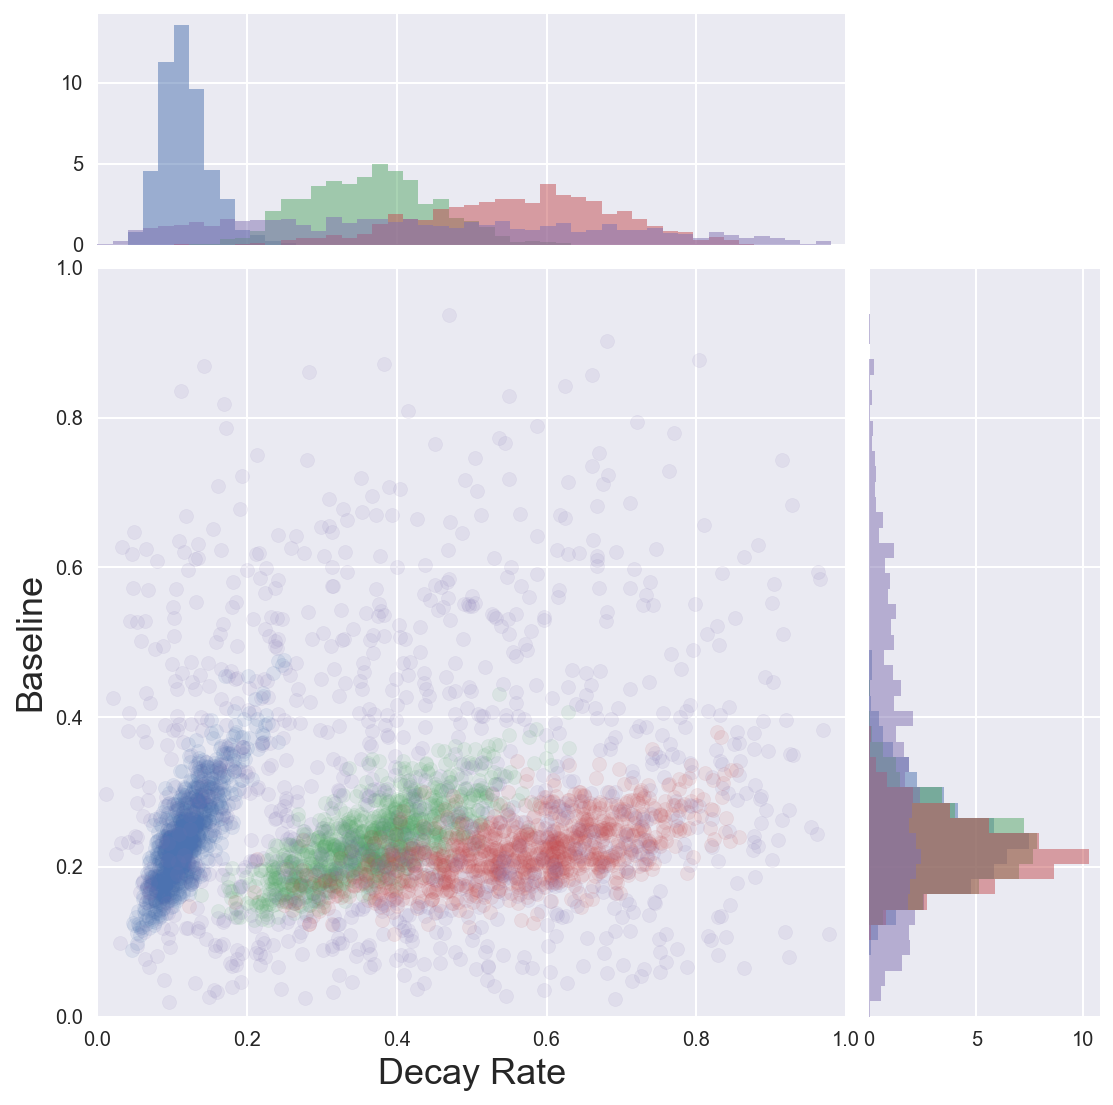

In [17]:
scatter_alpha_beta(trace3_)

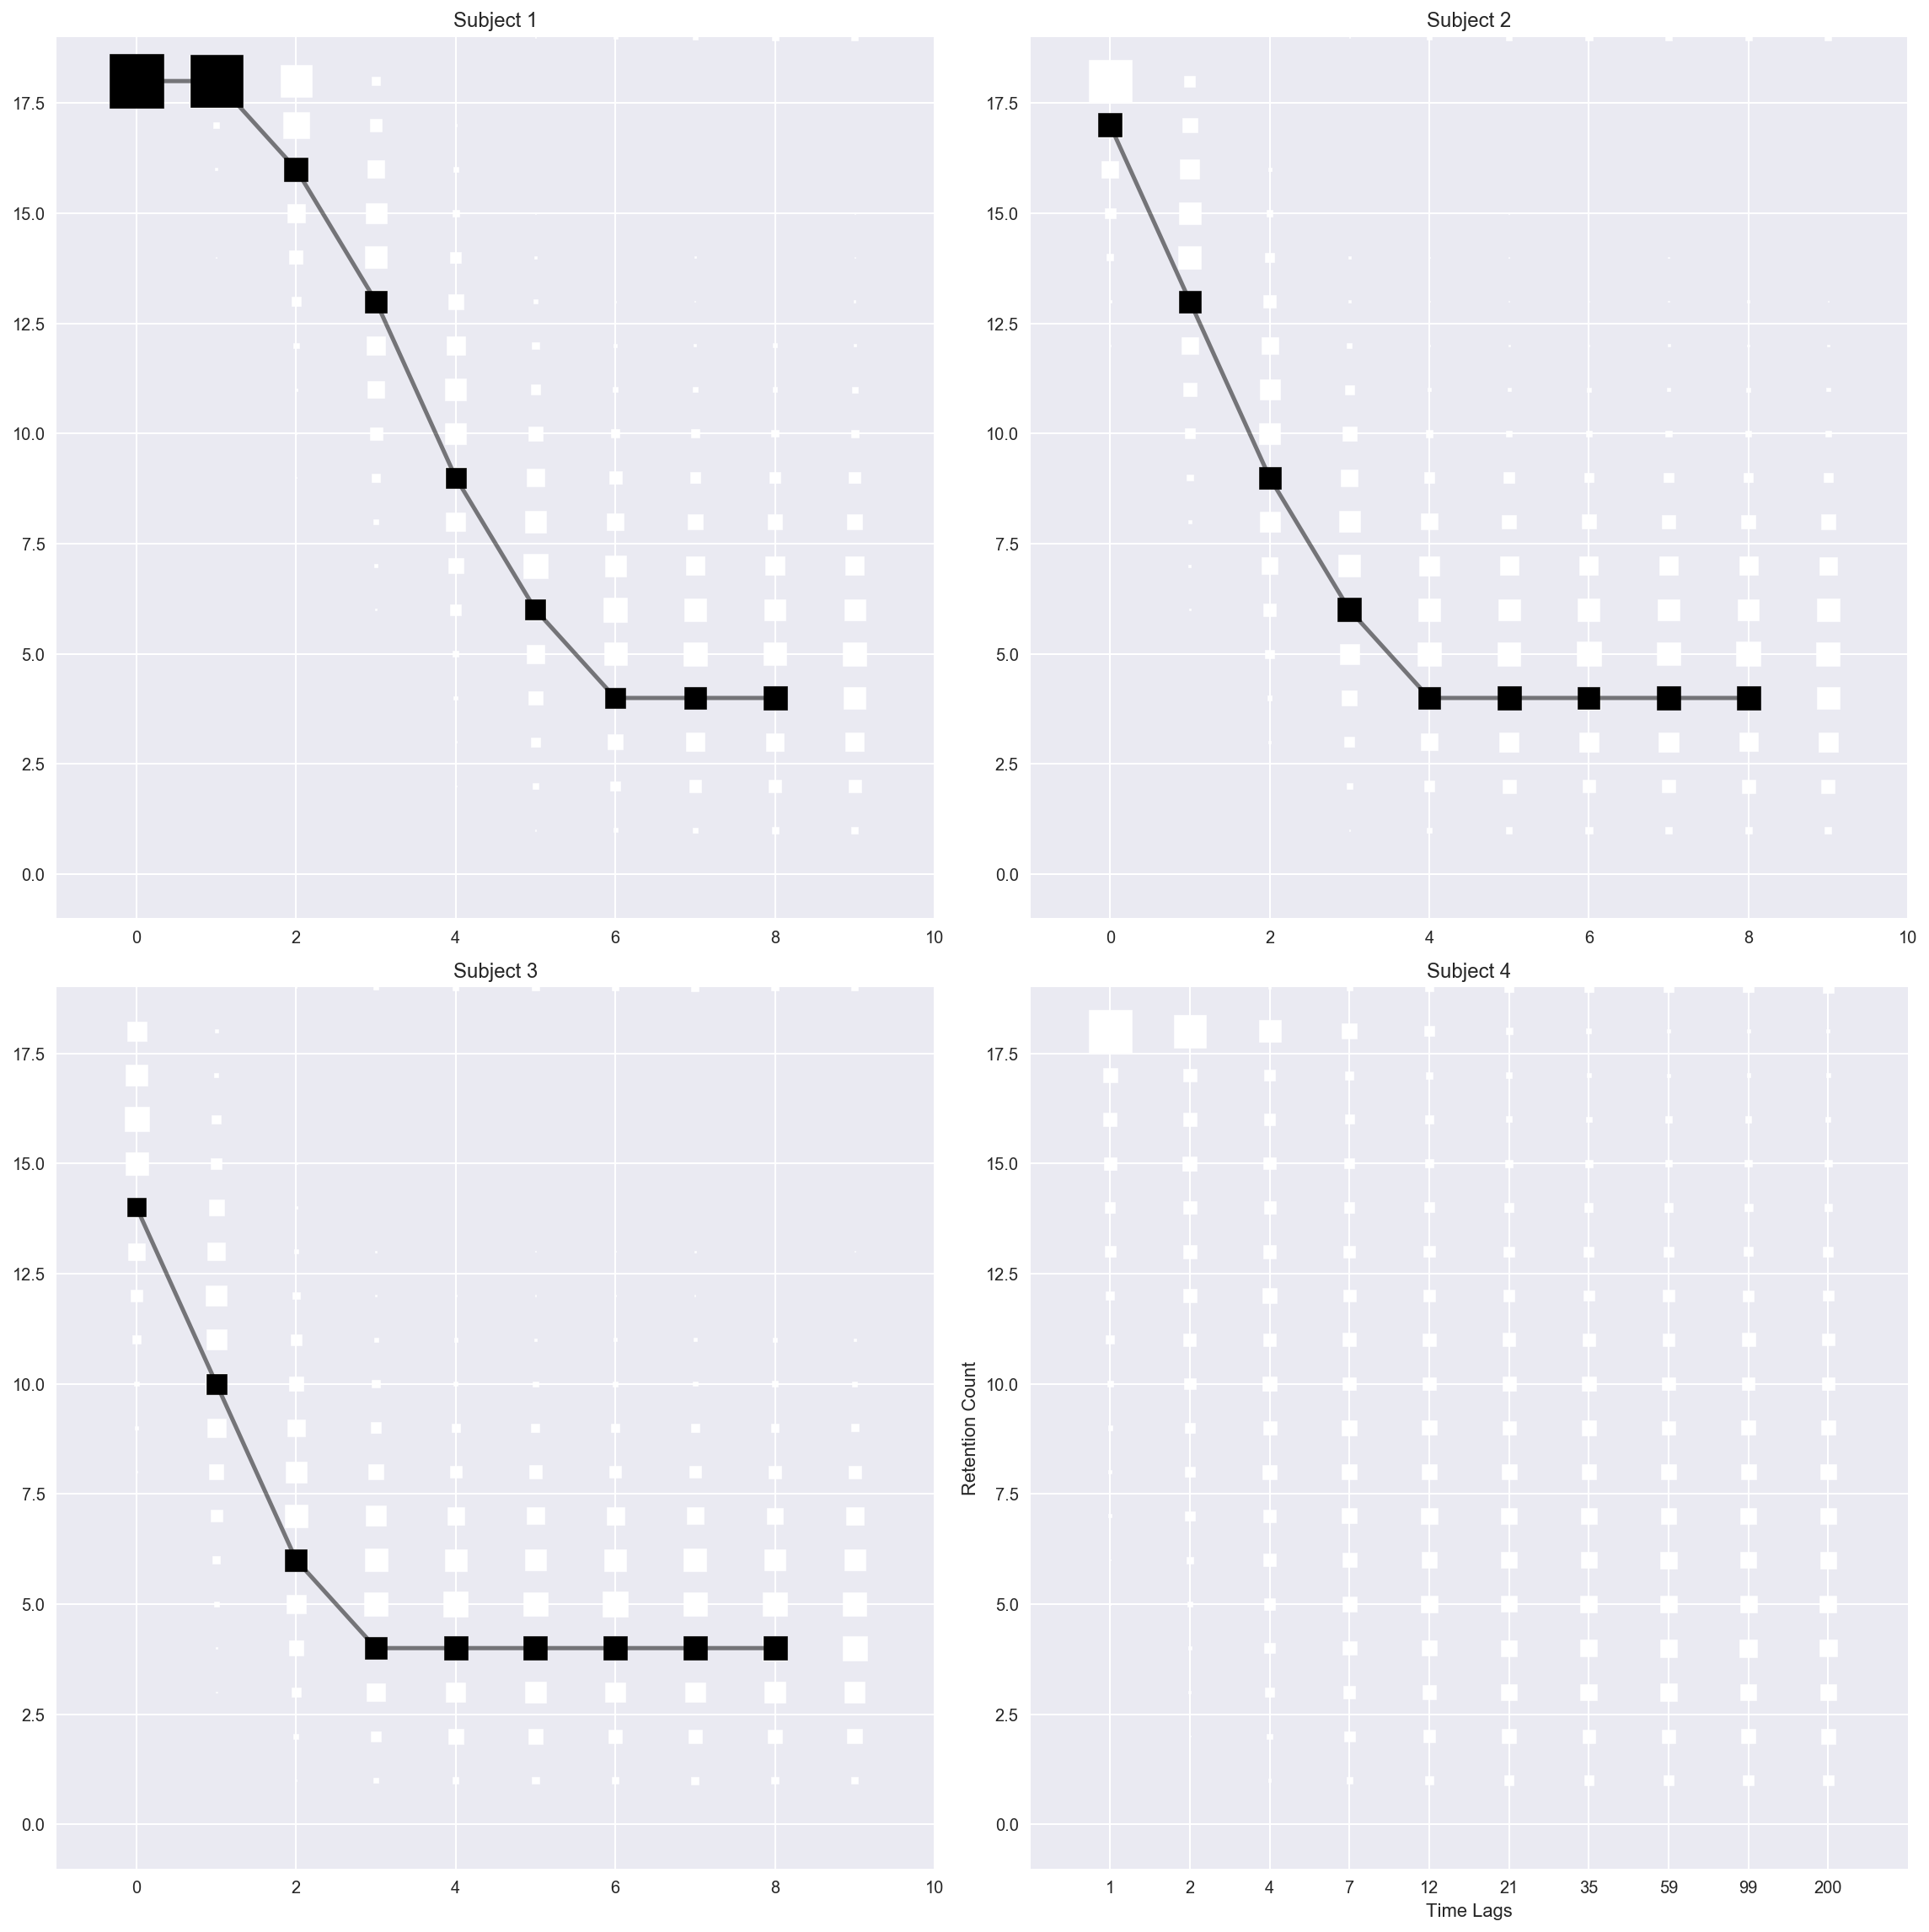

In [18]:
plot_predict(trace3_['kij_ppc'])